In [1]:
import numpy as np
import pandas as pd
import glob
import subprocess as sp
import os
from matplotlib import pyplot as plt
from ellipse import LsqEllipse
import cv2
import math
import scipy.stats as stats
from tqdm import tqdm

In [2]:
def oe_events_parser(open_ephys_csv_path, channel_names, export_path=None):
    """
    :param open_ephys_csv_path: The path to an open ephys analysis tools exported csv (using TrialReporter.ipynb)
    :param channel_names: a dictionary of the form -
                    { 1 : 'channel name' (L_eye_camera)
                      2 : 'channel name' (Arena_TTL)
                      etc..
                    }
    :param export_path: default None, if a path is specified a csv file will be saved
    :returns open_ephys_events: a pandas DataFrame object where each column has the ON events of one channel
                                and has a title from channel_names
    :returns open_ephys_off_events: same but for the OFF states (only important for the logical start-stop signal)
    """

    # Infer the active channels:
    df = pd.read_csv(open_ephys_csv_path)
    channels = df['channel'].to_numpy(copy=True)
    channels = np.unique(channels)
    df_onstate = df[df['state']==1] #cut the df to represent only rising edges
    df_offstate = df[df['state']==0] # This one is important for the ON/OFF signal of the arena
    list = []
    off_list= []
    for chan in channels: #extract a pandas series of the ON stats timestamps for each channel
        Sname = channel_names[chan]
        s = pd.Series(df_onstate['timestamp'][df_onstate['channel'] == chan], name=Sname)
        offs = pd.Series(df_offstate['timestamp'][df_offstate['channel'] == chan], name=Sname)
        list.append(s)
        off_list.append(offs)
    open_ephys_events = pd.concat(list, axis=1)
    open_ephys_off_events = pd.concat(off_list, axis=1)
    if export_path is not None :
        if not export_path in os.listdir(open_ephys_csv_path.split('events.csv')[0][:-1]):
            open_ephys_events.to_csv(export_path)
    return open_ephys_events , open_ephys_off_events

def convert_h264_mp4(path):
    files_to_convert = glob.glob(path + r'\**\*.h264', recursive=True)
    converted_files = glob.glob(path + r'\**\*.mp4', recursive=True)
    for file in files_to_convert:
        fps = file[file.find('hz') - 2:file.find('hz')]
        if len(fps) != 2:
            fps = 60
            print('could not determine fps, using 60...')
        if not str(fr'{file[:-5]}.mp4') in converted_files:
            sp.run(f'MP4Box -fps {fps} -add {file} {file[:-5]}.mp4')
            print(fr'{file} converted ')
        else:
            print(f'The file {file[:-5]}.mp4 already exists, no conversion necessary')

def validate_no_framedrop(path):
    videos_to_inspect = glob.glob(path + r'\**\*.mp4', recursive=True)
    timestamps_to_inspect = glob.glob(path + r'\**\*.csv', recursive=True)
    for vid in range(len(videos_to_inspect)):
        timestamps = pd.read_csv(timestamps_to_inspect[vid])
        num_reported = timestamps.shape[0]
        cap = cv2.VideoCapture(videos_to_inspect[vid])
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f'The video named {os.path.split(videos_to_inspect[vid])[1]} has reported {num_reported} frames '
              f'and has {length} frames, it has dropped {num_reported - length} frames')
        cap.release()

def stamp_diff_videos(path_to_stamp,stamp):
    videos_to_stamp = glob.glob(path_to_stamp + r'\**\*.mp4', recursive=True)
    for vid in videos_to_stamp:
        os.rename(vid, fr'{vid[:-4]}_{stamp}{vid[-4:]}')

def get_frame_timeseries(df,channel):
    index_range = range(0,len(df[channel][df[channel].notna()]))
    timeseries = pd.Series(df[channel][df[channel].notna()])
    timeseries = pd.Series(timeseries.values, index=index_range, name=channel)
    return timeseries

def get_closest_frame(timestamp, vid_timeseries, report_acc=None):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param vid_timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs((vid_timeseries.to_numpy())-timestamp)
    index_of_lowest_diff = np.argmin(array)
    if report_acc == 1:
        accuracy = abs(vid_timeseries[index_of_lowest_diff] - timestamp)
        return index_of_lowest_diff, accuracy
    else:
        return index_of_lowest_diff

def arena_video_initial_thr(vid_path, threshold_value, show_frames=False):
    """
        This function works through an arena video to determine where the LEDs are on and when off
        :param threshold_value: value of the frame threshold
        :param show_frames: if true will show the video after thresholding
        :param  vid_path: Path to video. When ShowFrames is True a projection of the frames after threshold is presented

        :return: np.array with frame numbers and mean values after threshold
        """
    cap = cv2.VideoCapture(vid_path)
    all_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    flag = 0
    i = 0
    mean_values = []
    indexes = []
    while flag == 0:
        print('Frame number {} of {}'.format(i, all_frames), end='\r', flush=True)
        ret, frame = cap.read()
        if not ret:
            break
        grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        grey[grey < threshold_value] = 0
        mean_values.append(np.mean(grey))
        indexes.append(i)
        if show_frames:
            cv2.imshow('Thresholded_Frames', grey)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        i += 1
    cap.release()
    cv2.destroyAllWindows()
    frame_val = np.array((indexes, mean_values))
    return frame_val

def produce_frame_val_list(vid_paths,threshold_value):
    """
    :param vid_paths: a list of str paths to videos for analysis
    :param threshold_value: the threshold to use in order to concentrate on LEDs
    :return: frame_val_list: a list of mean pixel values for each frame after threshold
    """
    frame_val_list = []
    for vid in vid_paths:
        print(f'working on video {vid}')
        frame_val = arena_video_initial_thr(vid, threshold_value)
        frame_val_list.append(frame_val)
    print(f'done, frame_val_list contains {len(frame_val_list)} objects',flush=True)

    return frame_val_list

def four_video_concat(output_name, vid1, vid2, vid3, vid4,  start_frame, shortest_vid_length, format='H264'):
    """
    :param vid1: left down
    :param vid2: right down
    :param vid3: left up
    :param vid4: right up
    :param shortest_vid_length:
    :param output_name: output file name
    :return: a concatenated video of the 4 inputs
    """
    cap0 = cv2.VideoCapture(vid1)
    cap1 = cv2.VideoCapture(vid2)
    cap2 = cv2.VideoCapture(vid3)
    cap3 = cv2.VideoCapture(vid4)
    anchor = start_frame
    last_ar_f = sync_vids.Arena_VideoFrame[start_frame]
    last_le = sync_vids.Left_eye[start_frame]
    last_re = sync_vids.Right_eye[start_frame]
    fourcc = cv2.VideoWriter_fourcc(*format)
    out = cv2.VideoWriter((path + r'\\' + output_name + '.mp4'),fourcc, 60.0, (640*2,480*2))
    try:
        while cap2.isOpened():
            ar_f = sync_vids.Arena_VideoFrame[anchor]
            l_eye_f = sync_vids.Left_eye[anchor]
            r_eye_f = sync_vids.Right_eye[anchor]

            if ar_f != last_ar_f + 1:
                cap0.set(1,ar_f)
            ar_ret0, ar_frame0 = cap0.read()
            ar_frame0 = cv2.cvtColor(ar_frame0, cv2.COLOR_BGR2GRAY)
            ar_frame0 = cv2.resize(ar_frame0,(640,480))
            last_ar_f = ar_f

            if ar_f != last_ar_f + 1:
                cap1.set(1,ar_f)
            ar_ret, ar_frame = cap1.read()
            ar_frame = cv2.cvtColor(ar_frame, cv2.COLOR_BGR2GRAY)
            ar_frame = cv2.resize(ar_frame,(640,480))

            if l_eye_f != last_le + 1:
                cap2.set(1,l_eye_f)
            le_ret, le_f = cap2.read()
            le_f = cv2.cvtColor(le_f, cv2.COLOR_BGR2GRAY)
            le_f = cv2.flip(le_f, 0)
            le_f = cv2.resize(le_f,(640,480))
            last_le = l_eye_f

            if r_eye_f != last_re + 1:
                cap3.set(1,r_eye_f)
            re_ret, re_f = cap3.read()
            re_f = cv2.cvtColor(re_f, cv2.COLOR_BGR2GRAY)
            re_f = cv2.flip(re_f, 0)
            re_f = cv2.resize(re_f,(640,480))
            last_re = r_eye_f

            eye_concat = np.hstack((le_f,re_f))
            ar_concat = np.hstack((ar_frame0, ar_frame))
            vconcat = np.vstack((eye_concat, ar_concat))

            out.write(vconcat)
            anchor += 1
            print(f'writing video frame {anchor} out of {shortest_vid_length}', end='\r', flush=True)
            if anchor > shortest_vid_length-1:
                break
    except Exception:
        print(f'Encountered a problem with frame {anchor}, stopping concatenation')
    finally:
        cap0.release()
        cap1.release()
        cap2.release()
        cap3.release()
        out.release()
        cv2.destroyAllWindows()
        print('\n')
        print('Processed finished')

def eye_tracking_analysis(dlc_video_analysis_csv):
    """
    :param dlc_video_analysis_csv: the csv output of a dlc analysis of one video, already read by pandas with header=1
    :param bodyparts_list: a list of bodyparts as described in the dlc csv (i.e ['Pupil_12', 'Pupil_6'....])
    :returns ellipse_df: a DataFrame of ellipses parameters (center, width, height, phi, size) for each video frame

    """

    data = dlc_video_analysis_csv
    ellipses = []
    caudal_edge_ls= []
    rostral_edge_ls = []
    for row in range(1, len(data)-1):
        x_values = np.array(list([float(data['Pupil_12'][row]),
                                  float(data['Pupil_1'][row]),
                                  float(data['Pupil_3'][row]),
                                  float(data['Pupil_4'][row]),
                                  float(data['Pupil_6'][row]),
                                  float(data['Pupil_8'][row]),
                                  float(data['Pupil_10'][row])]))
        y_values = np.array(list([float(data['Pupil_12.1'][row]),
                                  float(data['Pupil_1.1'][row]),
                                  float(data['Pupil_3.1'][row]),
                                  float(data['Pupil_4.1'][row]),
                                  float(data['Pupil_6.1'][row]),
                                  float(data['Pupil_8.1'][row]),
                                  float(data['Pupil_10.1'][row])]))
        X = np.c_[x_values,y_values]

        el = LsqEllipse().fit(X)
        center, width, height, phi = el.as_parameters()
        center_x = center[0]
        center_y = center[1]
        ellipses.append([center_x,center_y,width,height,phi])
        caudal_edge = [
            float(data['Caudal_edge'][row]),
            float(data['Caudal_edge.1'][row])
        ]
        rostral_edge = [
            float(data['Rostral_edge'][row]),
            float(data['Rostral_edge.1'][row])
        ]
        caudal_edge_ls.append(caudal_edge)
        rostral_edge_ls.append(rostral_edge)
        if row % 50 == 0:
           print(f'just finished with {row} out of {len(data)-1}', end='\r',flush=True)
    ellipse_df = pd.DataFrame(columns = ['center_x','center_y', 'width', 'height', 'phi'], data = ellipses)
    a = np.array(ellipse_df['height'][:])
    b = np.array(ellipse_df['width'][:])
    ellipse_size_per_frame = a*b*math.pi
    ellipse_df['ellipse_size'] = ellipse_size_per_frame
    ellipse_df['rostral_edge'] = rostral_edge_ls
    ellipse_df['caudal_edge'] = caudal_edge_ls
    print('Done')
    return ellipse_df

In [ ]:
"""
This notebook should be the main sequence for incoming experimental data - there are prerequisites for a functional process:
- the process is designed to work block-by-block
- Data will be arranged into block folders under animal folders, where each block contains the next structure:

                                       /----> arena_videos  ->[config.yaml , info.yaml] videos -> [video files, output.log] timestamps -> [csv of timestamps]

Animal_x ->date(xx_xx_xxxx) -> block_x -----> eye_videos >> LE\RE -> video folder with name -> [video.h264 , video.mp4 , params.json , timestamps.csv]

                                       \----> oe_files >> date_time(xxxx_xx_xx_xx-xx-xx) --> [events.csv] internal open ephys structure from here (NWB format only!!!)
                                                                                             /////////////////////
                                                                                         TODO: internal parsing of this file
"""

In [3]:
animal_number = '0'
experiment_date = '24_03_2021'
block = '1'
path = rf'D:\experiments\Animal_{animal_number}\{experiment_date}\block_{block}'
print(path)
#Arena
arvid_path = path + r'\arena_videos\videos\*.mp4'
arena_videos = glob.glob(path + r'\arena_videos\videos\*.mp4')
print(arena_videos)


D:\experiments\Animal_0\24_03_2021\block_1
['D:\\experiments\\Animal_0\\24_03_2021\\block_1\\arena_videos\\videos\\back_20210324T113458.mp4', 'D:\\experiments\\Animal_0\\24_03_2021\\block_1\\arena_videos\\videos\\left_20210324T113458.mp4', 'D:\\experiments\\Animal_0\\24_03_2021\\block_1\\arena_videos\\videos\\realtime_20210324T113458.mp4', 'D:\\experiments\\Animal_0\\24_03_2021\\block_1\\arena_videos\\videos\\stream_20210324T113458.mp4']


In [4]:
ar_vidnames = []
for vid in arena_videos:
    vidname = vid.split(sep="\\") ; vidname = vidname[len(vidname)-1]
    vidname=vidname.split(sep='.') ; vidname=vidname[0]
    ar_vidnames.append(vidname)
print(ar_vidnames)

['back_20210324T113458', 'left_20210324T113458', 'realtime_20210324T113458', 'stream_20210324T113458']


In [6]:
vid_path = path + r'\eye_videos'
print('converting videos...')
convert_h264_mp4(vid_path)
print('Validating videos...')
validate_no_framedrop(vid_path)

converting videos...
D:\experiments\Animal_0\24_03_2021\block_1\eye_videos\LE\cospecifics5min_2_640x480_60hz_experiment_1_recording_0\cospecifics5min_2.h264 converted 
The file D:\experiments\Animal_0\24_03_2021\block_1\eye_videos\RE\cospecifics5min_2_640x480_60hz_experiment_1_recording_0\cospecifics5min_2.mp4 already exists, no conversion necessary
Validating videos...
The video named cospecifics5min_2.mp4 has reported 26301 frames and has 26299 frames, it has dropped 2 frames
The video named cospecifics5min_2_LE.mp4 has reported 26299 frames and has 26299 frames, it has dropped 0 frames
The video named cospecifics5min_2.mp4 has reported 26306 frames and has 26304 frames, it has dropped 2 frames


In [ ]:
print('stamping LE video')
stamp_diff_videos(vid_path+r'\LE' , 'LE')

In [5]:
le_video = glob.glob(path + r'\eye_videos\LE\**\*.mp4')
re_video = glob.glob(path + r'\eye_videos\RE\**\*.mp4')

In [6]:
channeldict = {
    5 : 'L_eye_TTL',
    6 : 'Arena_TTL',
    7 : 'Logical ON/OFF',
    8 : 'R_eye_TTL'
}
exp_date_time = os.listdir(fr'{path}\oe_files')[0]
oe_events , oe_off_events = oe_events_parser(path + rf'\oe_files\{exp_date_time}\events.csv',
                                             channeldict,
                                             export_path=path + rf'\oe_files\{exp_date_time}\parsed_events.csv')
ts_list = []
for chan in list(oe_events.columns):
    ts = get_frame_timeseries(oe_events,str(chan))
    ts_list.append(ts)
logical_off_series = get_frame_timeseries(oe_off_events,'Logical ON/OFF')
block_start_time = ts_list[2].values[0]
del ts_list[2]
block_end_time = logical_off_series.values[0]


In [8]:
print(f'Arena video start: {block_start_time} \n'
      f'Arena video end: {block_end_time} \n'
      f'Block length: {block_end_time - block_start_time} Seconds')

Arena video start: 10.976449966430664 
Arena video end: 464.2591552734375 
Block length: 453.28270530700684 Seconds


In [9]:
#Arena
arena_ff = ts_list[1].values[ts_list[1]>block_start_time][0]
arena_first_index = ts_list[1][ts_list[1] == arena_ff].index
arena_lf = ts_list[1].values[ts_list[1]<block_end_time][-1]
arena_last_index = ts_list[1][ts_list[1] == arena_lf].index
arena_sync_s = pd.Series(ts_list[1][arena_first_index.asi8[0] : arena_last_index.asi8[0]])

#Left eye
le_ff = ts_list[0].values[0]
le_first_index = ts_list[0][ts_list[0] == le_ff].index
le_lf = ts_list[0].values[-1]
le_last_index = ts_list[0][ts_list[0] == le_lf].index
le_sync_s = ts_list[0]

#Right eye
re_ff = ts_list[2].values[0]
re_first_index = ts_list[2][ts_list[2] == re_ff].index
re_lf = ts_list[2].values[-1]
re_last_index = ts_list[2][ts_list[2] == re_lf].index
re_sync_s = ts_list[2]

sync_time_starts = max([arena_ff, le_ff, re_ff])
sync_time_ends = min([arena_lf, le_lf, re_lf])

In [10]:
#Define Anchor signal
anchor_signal = np.arange(sync_time_starts, sync_time_ends, 1/60)

#Create the DataFrame
sync_vids = pd.DataFrame(data=None,
                         index=range(len(anchor_signal)),
                         columns=['Left_eye','Arena','Arena_VideoFrame','Right_eye'])

accuracy_report = pd.DataFrame(data=None,
                               index=range(len(anchor_signal)),
                               columns=['Left_eye','Arena','Right_eye'])

# define dictionary for timestamp retrieval
ts_dict = {'Left_eye': ts_list[0],
           'Arena': ts_list[1],
           'Right_eye':ts_list[2]}

#Iterate over the length of the dataframe and fit
for frame in range(len(anchor_signal)):
    anchor_time = anchor_signal[frame]
    if frame % 50 == 0:
        print(f'frame {frame} out of {len(anchor_signal)}', end='\r', flush=True)
    for vid in ['Left_eye', 'Right_eye', 'Arena']:
        f,a = get_closest_frame(anchor_time, ts_dict[vid], report_acc=1)
        sync_vids[vid][frame] = f
        accuracy_report[vid][frame] = a

In [89]:
sync_vids.Arena_VideoFrame = sync_vids.Arena - (arena_first_index.asi8[0] - 4)
sync_vids.Right_eye = sync_vids.Right_eye
sync_vids

,Left_eye,Arena,Arena_VideoFrame,Right_eye
0,6,1930,1349,12
1,7,1931,1350,13
2,8,1932,1351,14
3,9,1933,1352,15
4,10,1934,1353,16
...,...,...,...,...
25720,25773,27112,26531,25779
25721,25774,27113,26532,25780
25722,25775,27114,26533,25781
25723,25776,27115,26534,25782


In [13]:
arena_frame_val_list = produce_frame_val_list(arena_videos,250)

working on video D:\experiments\Animal_0\24_03_2021\block_1\arena_videos\videos\back_20210324T113458.mp4
working on video D:\experiments\Animal_0\24_03_2021\block_1\arena_videos\videos\left_20210324T113458.mp4
working on video D:\experiments\Animal_0\24_03_2021\block_1\arena_videos\videos\realtime_20210324T113458.mp4
working on video D:\experiments\Animal_0\24_03_2021\block_1\arena_videos\videos\stream_20210324T113458.mp4
done, frame_val_list contains 4 objects


In [14]:
l_eye_frame_val_list = produce_frame_val_list(le_video, 30)
r_eye_frame_val_list = produce_frame_val_list(re_video,30)

working on video D:\experiments\Animal_0\24_03_2021\block_1\eye_videos\LE\cospecifics5min_2_640x480_60hz_experiment_1_recording_0\cospecifics5min_2_LE.mp4
done, frame_val_list contains 1 objects
working on video D:\experiments\Animal_0\24_03_2021\block_1\eye_videos\RE\cospecifics5min_2_640x480_60hz_experiment_1_recording_0\cospecifics5min_2.mp4
done, frame_val_list contains 1 objects


In [17]:
l_eye_values = stats.zscore(l_eye_frame_val_list[0][1])
r_eye_values = stats.zscore(r_eye_frame_val_list[0][1])

In [18]:
sync_vids.Arena_VideoFrame

0         1345
1         1346
2         1347
3         1348
4         1349
         ...  
25720    26527
25721    26528
25722    26529
25723    26530
25724    26531
Name: Arena_VideoFrame, Length: 25725, dtype: object

In [90]:
arena_brightness_df = pd.DataFrame(index = anchor_signal)
for ind, vid in enumerate(ar_vidnames):
    vid_val_arr = stats.zscore(arena_frame_val_list[ind][1])
    sync_list = sync_vids.Arena_VideoFrame.astype(int)
    sync_list[sync_list >= len(vid_val_arr)] = len(vid_val_arr)-1
    arena_brightness_df.insert(loc=0,
                               column=str(vid),
                               value=vid_val_arr[sync_list])

In [91]:
eye_brightness_df = pd.DataFrame(index=anchor_signal)
eye_brightness_df.insert(loc=0,
                         column='left_eye',
                         value=l_eye_values[sync_vids.Left_eye.values.astype(int)[0:len(anchor_signal)]])
eye_brightness_df.insert(loc=0,
                         column='right_eye',
                         value=r_eye_values[sync_vids.Right_eye.values.astype(int)[0:len(anchor_signal)]])

In [53]:
arena_brightness_df

,stream_20210324T113458,realtime_20210324T113458,left_20210324T113458,back_20210324T113458
35.507351,-0.991929,1.076827,-0.714587,-0.409468
35.524018,-0.848033,1.081110,-0.746383,-0.409468
35.540684,-0.980735,1.076827,-0.732089,-0.418423
35.557351,-0.925151,1.076579,-0.741517,-0.486974
35.574018,-0.836839,1.008360,-0.756924,-0.476513
...,...,...,...,...
464.174018,1.362104,0.291870,0.402599,0.764541
464.190684,1.281569,0.273355,0.395332,0.755007
464.207351,1.332795,0.297676,0.395332,0.714286
464.224018,1.323738,0.291905,0.370824,0.745203


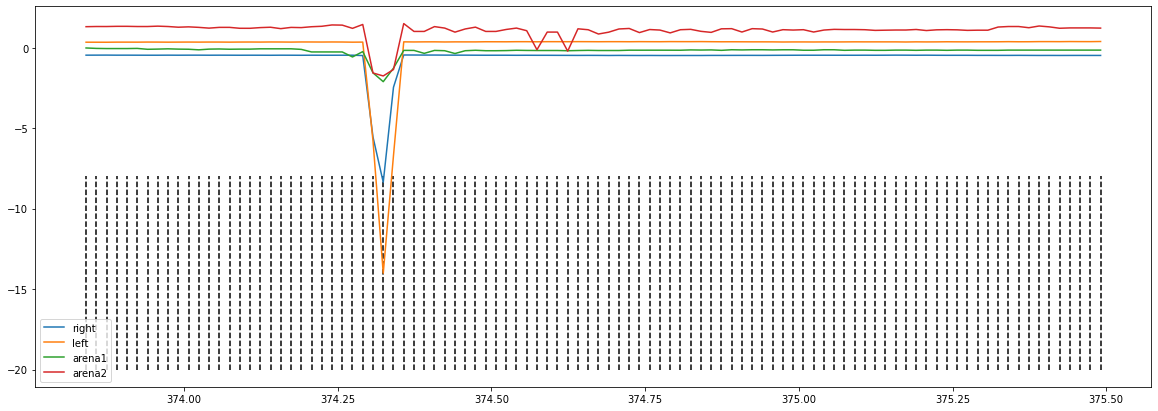

In [103]:
sec = 3600
x = 5
region = range(2300+x*sec, 2400+x*sec)

plt.figure(figsize=[20,7])
plt.plot(eye_brightness_df.iloc[region].index, eye_brightness_df.iloc[region].right_eye, label='right')
plt.plot(eye_brightness_df.iloc[region].index, eye_brightness_df.iloc[region].left_eye, label='left')
plt.plot(eye_brightness_df.iloc[region].index, arena_brightness_df.iloc[region].realtime_20210324T113458, label='arena1')
plt.plot(eye_brightness_df.iloc[region].index, arena_brightness_df.iloc[region].stream_20210324T113458, label='arena2')
plt.vlines(eye_brightness_df.iloc[region].index, -20, -8, linestyles={'dashed'})
plt.legend()


In [98]:
sync_vids_validated = sync_vids
sync_vids_validated.insert(loc=0, column='Time', value=anchor_signal)
sync_vids_validated

,Time,Left_eye,Arena,Arena_VideoFrame,Right_eye
0,35.507351,6,1930,1349,12
1,35.524018,7,1931,1350,13
2,35.540684,8,1932,1351,14
3,35.557351,9,1933,1352,15
4,35.574018,10,1934,1353,16
...,...,...,...,...,...
25720,464.174018,25773,27112,26531,25779
25721,464.190684,25774,27113,26532,25780
25722,464.207351,25775,27114,26533,25781
25723,464.224018,25776,27115,26534,25782


In [100]:
sync_vids_validated.to_csv(path+r'\\vid_source_synchronization.csv')

In [ ]:
four_video_concat('block_9_synchronization',arena_videos[1],arena_videos[3],le_video[0],re_video[0],10,24900)


##### PHASE 2 #####

In [7]:
le_csv = pd.read_csv(glob.glob(path + r'\eye_videos\LE\**\*DLC*.csv')[0],header=1)

re_csv = pd.read_csv(glob.glob(path + r'\eye_videos\RE\**\*DLC*.csv')[0],header=1)


data = le_csv
ellipses = []
for row in range(1, len(data)-1):
    x_values = np.array(list([data.loc[row, 'Pupil_12']]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            ))

In [10]:
le_ellipses = eye_tracking_analysis(le_csv)
print('\n')
re_ellipses = eye_tracking_analysis(re_csv)

Done finished with 26250 out of 26299


Done finished with 26300 out of 26304


In [11]:
video_sync_df = pd.read_csv(path + r'\\vid_source_synchronization.csv')
video_sync_df = video_sync_df.drop(labels=['Unnamed: 0','Arena'],axis=1)

In [12]:
le_video_sync_df = video_sync_df.drop(labels=['Arena_VideoFrame','Right_eye'],axis=1)
for column in list(le_ellipses.columns):
    le_video_sync_df.insert(loc=len(le_video_sync_df.columns), column=column, value=None)
re_video_sync_df = video_sync_df.drop(labels=['Arena_VideoFrame','Left_eye'],axis=1)
for column in list(re_ellipses.columns):
    re_video_sync_df.insert(loc=len(re_video_sync_df.columns), column=column, value=None)

In [13]:
print('populating le_video_sync_df')
for row in tqdm(le_video_sync_df.index):
    frame = le_video_sync_df.Left_eye[row]
    le_video_sync_df.loc[row, 'center_x'] = le_ellipses.iloc[frame]['center_x']
    le_video_sync_df.loc[row, 'center_y'] = le_ellipses.iloc[frame]['center_y']
    le_video_sync_df.loc[row, 'width']= le_ellipses.width[frame]
    le_video_sync_df.loc[row, 'height'] = le_ellipses.height[frame]
    le_video_sync_df.loc[row, 'phi'] = le_ellipses.phi[frame]
    le_video_sync_df.loc[row, 'ellipse_size'] = le_ellipses.ellipse_size[frame]
    le_video_sync_df.at[row, 'rostral_edge'] = le_ellipses.rostral_edge[frame]
    le_video_sync_df.at[row, 'caudal_edge'] = le_ellipses.caudal_edge[frame]

100%|██████████| 25725/25725 [01:30<00:00, 285.10it/s]


populating le_video_sync_df


In [15]:
print('populating re_video_sync_df')
for row in tqdm(re_video_sync_df.index):
    frame = re_video_sync_df.Right_eye[row]
    re_video_sync_df.loc[row, 'center_x'] = re_ellipses.iloc[frame]['center_x']
    re_video_sync_df.loc[row, 'center_y'] = re_ellipses.iloc[frame]['center_y']
    re_video_sync_df.loc[row, 'width']= re_ellipses.width[frame]
    re_video_sync_df.loc[row, 'height'] = re_ellipses.height[frame]
    re_video_sync_df.loc[row, 'phi'] = re_ellipses.phi[frame]
    re_video_sync_df.loc[row, 'ellipse_size'] = re_ellipses.ellipse_size[frame]
    re_video_sync_df.at[row, 'rostral_edge'] = re_ellipses.rostral_edge[frame]
    re_video_sync_df.at[row, 'caudal_edge'] = re_ellipses.caudal_edge[frame]

100%|██████████| 25725/25725 [01:13<00:00, 350.26it/s]


populating re_video_sync_df


In [126]:
first_frame_time = le_video_sync_df.Time.values[0]
first_frame_time

35.50735092163086

In [118]:
fpm = 3600
x = 0
region = range(0+x*fpm, 3600+x*fpm)



(80.0, 180.0)

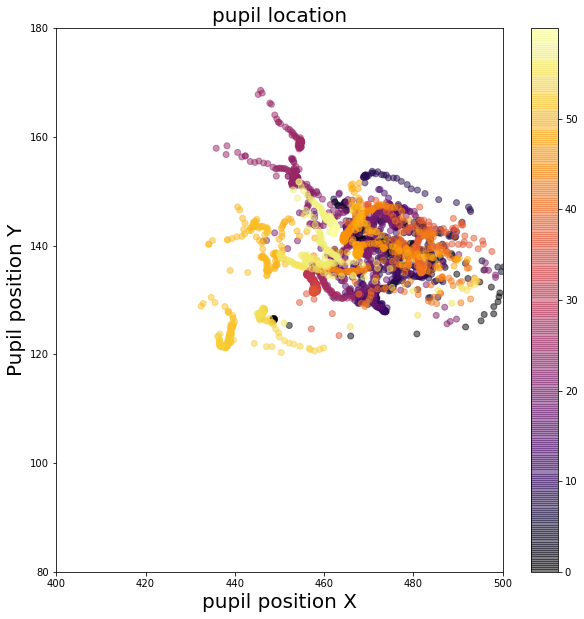

In [132]:
fig = plt.figure(figsize=[10,10])
fig.set_facecolor('xkcd:white')
plt.title('pupil location',fontsize=20)
plt.xlabel('pupil position X',fontsize=20)
plt.ylabel('Pupil position Y',fontsize=20)
plt.scatter(le_video_sync_df.center_x[region],
            le_video_sync_df.center_y[region],
            c=le_video_sync_df.Time[region] - first_frame_time,
            cmap='inferno',
            alpha=0.5,
            label='Left eye')
plt.colorbar()
#_ = plt.scatter(re_video_sync_df.center_x[region],re_video_sync_df.center_y[region],
            # label='Right eye',
            # c=re_video_sync_df.Time[region],
            # cmap='jet',
            # alpha=0.5)
plt.xlim(400,500)
plt.ylim(80,180)

In [120]:
pupil_distance_p = (le_video_sync_df.center_x - re_video_sync_df.center_x)**2 + \
                 (le_video_sync_df.center_y - re_video_sync_df.center_y)**2
pupil_convergence = []
for val in pupil_distance_p.values:
    pupil_convergence.append(math.sqrt(val))


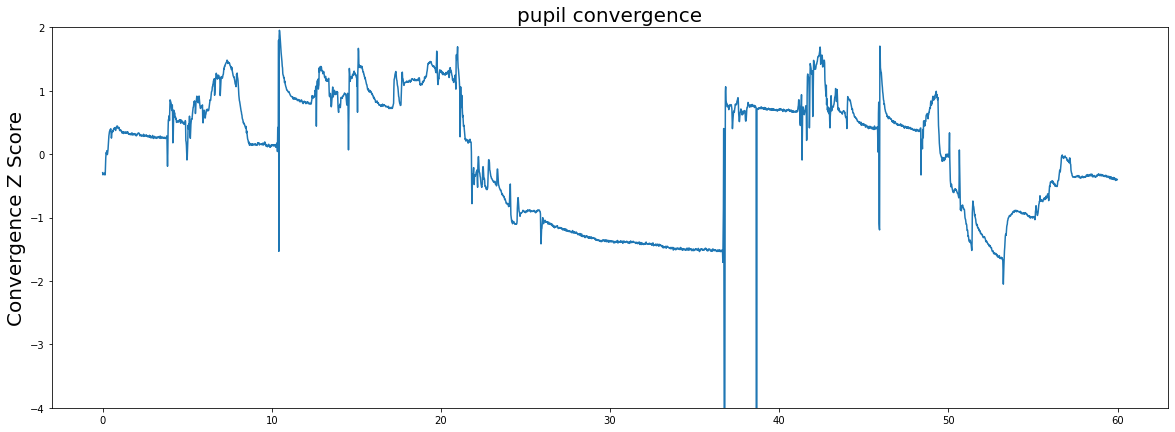

In [127]:
fig = plt.figure(figsize=[20,7])
fig.set_facecolor('xkcd:white')
plt.title('pupil convergence',fontsize=20)
plt.ylabel('Convergence Z Score', fontsize=20)
plt.plot(le_video_sync_df.Time[region] - first_frame_time, stats.zscore(np.array(pupil_convergence)[region]))
_ = plt.ylim(-4,2)

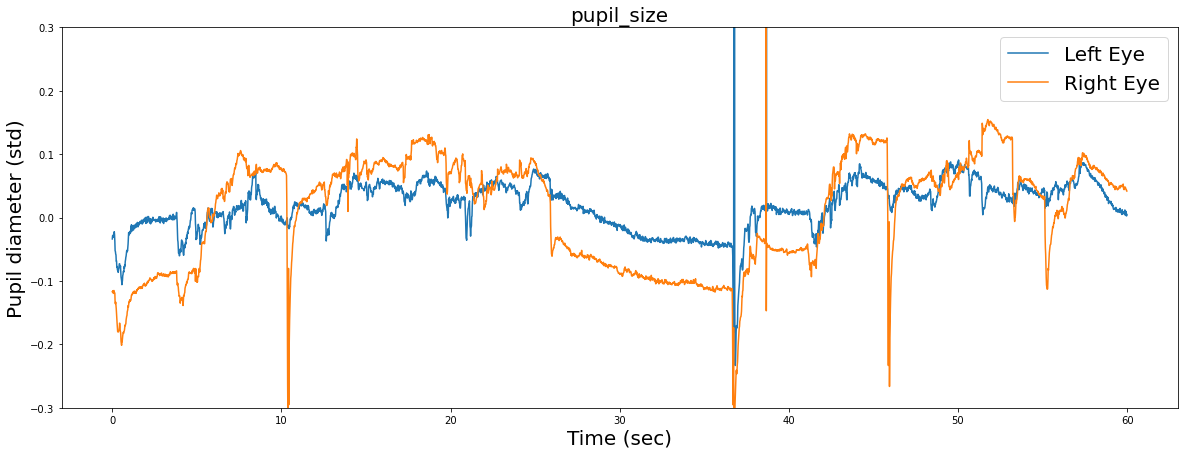

In [130]:
le_ellipses_z = (le_video_sync_df.ellipse_size - le_video_sync_df.ellipse_size.mean()) / le_video_sync_df.ellipse_size.std()
re_ellipses_z = (re_video_sync_df.ellipse_size - re_video_sync_df.ellipse_size.mean()) / re_video_sync_df.ellipse_size.std()
fig = plt.figure(figsize=[20,7])
fig.set_facecolor('xkcd:white')
plt.title('pupil_size',fontsize=20)
plt.xlabel('Time (sec)',fontsize=20)
plt.ylabel('Pupil diameter (std)',fontsize=20)
plt.plot(le_video_sync_df.Time[region] - first_frame_time, le_ellipses_z[region],label='Left Eye')
plt.plot(re_video_sync_df.Time[region] - first_frame_time, re_ellipses_z[region],label='Right Eye')
#plt.xticks(np.arange(min(le_video_sync_df.Time[region] - first_frame_time), max(le_video_sync_df.Time[region])+1,0.5))
plt.ylim(-0.3,0.3)
_=plt.legend(fontsize=20)

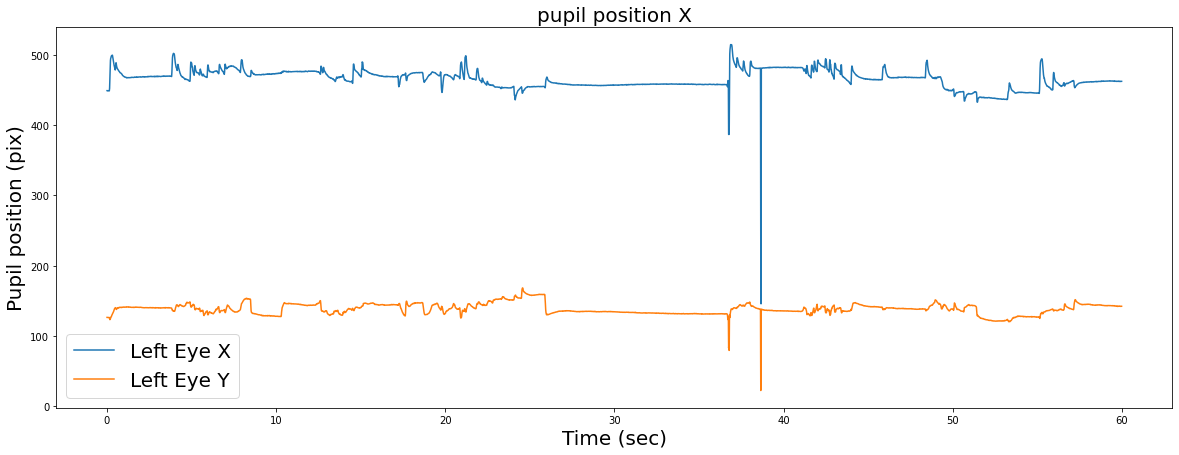

In [137]:
#pos_y_z = (le_video_sync_df.ellipse_size - le_video_sync_df.center_y.mean()) / le_video_sync_df.center_y.std()
#pos_y_z = (le_video_sync_df.ellipse_size - le_video_sync_df.center_x.mean()) / le_video_sync_df.center_x.std()
fig = plt.figure(figsize=[20,7])
fig.set_facecolor('xkcd:white')
plt.title('pupil position X',fontsize=20)
plt.xlabel('Time (sec)',fontsize=20)
plt.ylabel('Pupil position (pix)',fontsize=20)
plt.plot(le_video_sync_df.Time[region] - first_frame_time, le_video_sync_df.center_x[region],label='Left Eye X')
plt.plot(le_video_sync_df.Time[region] - first_frame_time, le_video_sync_df.center_y[region],label='Left Eye Y')
#ync_df.Time[region] - first_frame_time, re_ellipses_z[region],label='Right Eye')
#plt.xticks(np.arange(min(le_video_sync_df.Time[region] - first_frame_time), max(le_video_sync_df.Time[region])+1,0.5))
#plt.ylim(-0.3,0.3)
_=plt.legend(fontsize=20)

